# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [2]:
from top2vec import Top2Vec

import os
import spacy
import unidecode
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


2024-05-17 12:58:30.764622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 12:58:30.910203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-17 12:58:30.910227: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-17 12:58:31.649631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

# Data and sources


## Prints for Koppermaandag
From the 18th century onwards, so called "Koppermaandagprenten" are retained in cultural heritage institutes. These prints are a proof of the quality of printing that a printshop was able to deliver. The labourers of a printshop made a print and brought them to the customers, expecting them to buy the print, or give a tip. This extra income was used to buy drinks on "Koppermaandag", a celebration on the first Monday after Epiphany.

In 1991, an important publication is made about this type of printwork, with an overview of the retained Koppermaandagprenten. From this book the counts per year are available.

In [3]:
prentenDF = pd.read_csv("data/koppermaandagprentenCount.csv", index_col="year")

print("Number of prints: "+ str(prentenDF['count'].sum()))


Number of prints: 554


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [4]:
liedjesDF = pd.read_csv("data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    771
Number of booklets:  64


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [5]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.lower().split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [6]:
liedjesFilenames    = getlistOfFilenames('data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee", "immer", "t", "d", "wijze", "hurah"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [7]:
n = 106

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                             amsterdam1849
sourceID                         amsterdam1849-feestliederen1863
songID                        amsterdam1849-feestliederen1863-04
titel                   Hulde en dank aan het werkend gezelschap
wijze                                     Marchand de parapluies
jaartal                                                     1863
schrijver                                        R. van der Star
vereniging_schrijver                               amsterdam1849
Name: 170, dtype: object
-- path: --
data/lyrics/amsterdam1849/amsterdam1849-feestliederen1863/amsterdam1849-feestliederen1863-04.txt
-- song: --
Hulde en dank aan het werkend gezelschap

Wij vieren thans weder ons jaarlijksche Feest
En doen het als altijd met vrolijken geest.
In vroegeren dagen ,
Kon ’t zoo niet behagen, |
Zoo als het nu heden toch gaat.
Gij Werkende Kring,
Blijft zoo onderling,
Voor Voorzorgs Genoegen steeds waken.
Blijft zoo op den duur,
Met kr

# Count 
The development of the number of particular retained heritage of printing in the nineteenth century might say something about the change of relevance for printers to create these prints. In this notebook the development of printing heritage is investigated.



## Number of Koppermaandagprenten per year
First, we study the number of Koppermaandagprenten per year. We smooth the count with a five year rolling mean. We observe two timeperiods where the making of these prints was popular: the 1820's and between 1840-1860.

Text(0, 0.5, 'number (rolling mean over 5 years)')

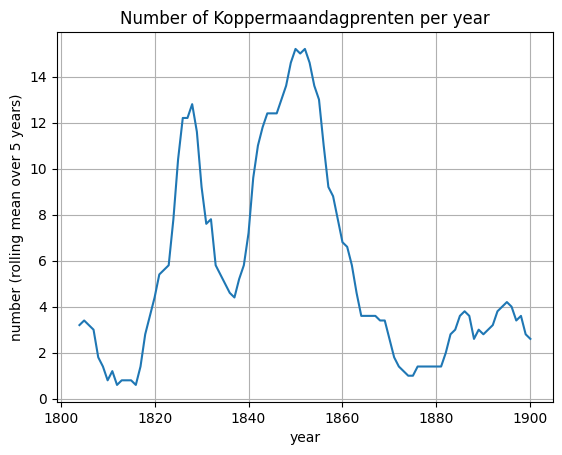

In [8]:
ax = prentenDF['count'].rolling(5).mean().plot(title="Number of Koppermaandagprenten per year", grid=True)
ax.set_ylabel('number (rolling mean over 5 years)')


## Number of songs and number of words per year
Secondly, we want to investigate how much songs are in the dataset per year. We smooth the outcome again with a five years rolling mean. We observe a popularity for creating songs between 1850 en 1865.

<AxesSubplot: xlabel='jaartal'>

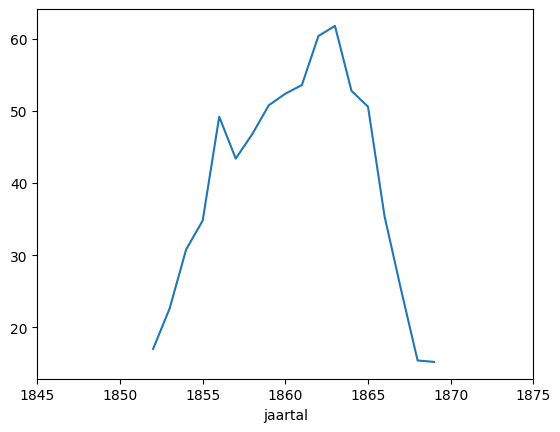

In [9]:
liedjesDF.groupby('jaartal').size().rolling(5).mean().plot(xlim=(1845,1875))

We study the number of words per year, instead of the number of songs per year for a potentially more precise indication. We calculate the number of words per song and add this to the liedjes DataFrame.

(array([ 0.,  0.,  2.,  3.,  3.,  6., 10., 18., 23., 42., 32., 63., 75.,
        80., 54., 43., 41., 43., 44., 28., 35., 16., 19., 23., 14., 13.,
         5., 11.,  4.,  4.,  2.,  2.,  0.,  3.,  3.,  0.,  1.,  1.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195.]),
 <BarContainer object of 39 artists>)

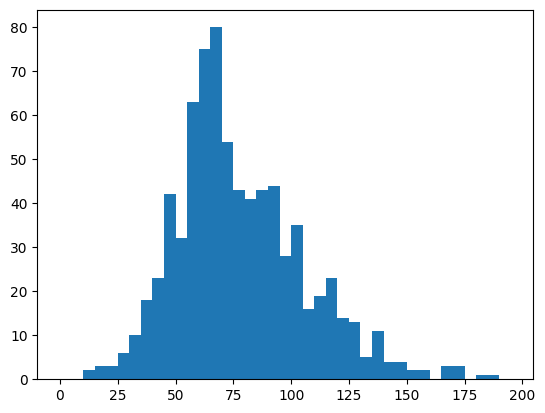

In [10]:
numberOfSongs = len(liedjes)

listOfWordlists = [] 
for i in range(0,numberOfSongs): listOfWordlists.append(preprocessedLiedjes[i].split())

listOfWordcounts = []
for i in range(0,numberOfSongs): listOfWordcounts.append(len(listOfWordlists[i]))

plt.hist(listOfWordcounts, bins=range(0,200,5), range=[0,200])


In [11]:
liedjesDF['wordcount'] = listOfWordcounts
liedjesDF.iloc[n]


typoID                                             amsterdam1849
sourceID                         amsterdam1849-feestliederen1863
songID                        amsterdam1849-feestliederen1863-04
titel                   Hulde en dank aan het werkend gezelschap
wijze                                     Marchand de parapluies
jaartal                                                     1863
schrijver                                        R. van der Star
vereniging_schrijver                               amsterdam1849
wordcount                                                     77
Name: 170, dtype: object

<AxesSubplot: xlabel='jaartal'>

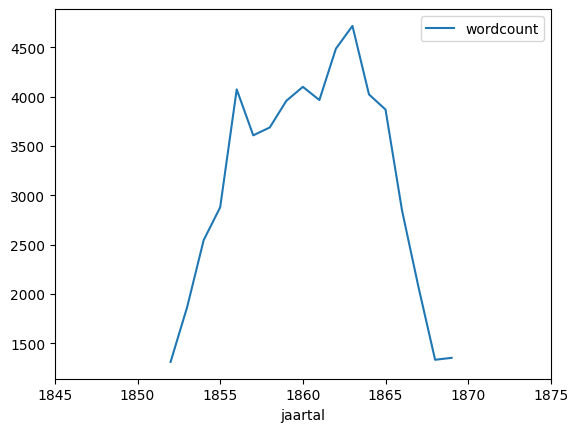

In [12]:
liedjesDF.groupby('jaartal').sum('wordcount').rolling(5).mean().plot(xlim=(1845,1875))

## Average size of a song per year
So the number of songs and the total number of words in the lyrics per year does not differ that much. How about the average size of a song per year? 

<AxesSubplot: xlabel='jaartal'>

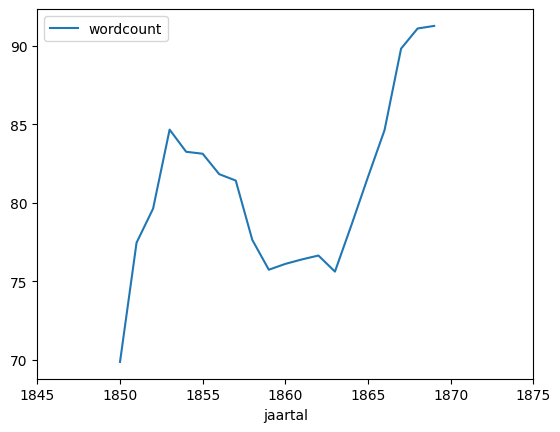

In [13]:
liedjesDF.groupby('jaartal').mean('wordcount').rolling(3).mean().plot(xlim=(1845,1875))

## Number of booklets per year
The number of booklets per year. Some booklets contain larger collections of songs through time of one typographical association (Middelburg) or of various associations on one moment (on the occasion of the erection of the statue of Coster in Haarlem 1856). We create a slice of the DataFrame without these books (with more than 50 songs) to have a better overview of the books created by associations in their own reasons. For the same reason we remove from this slice the singular songs that are retained over time (so we select booklets we at least 3 songs).

<AxesSubplot: xlabel='year'>

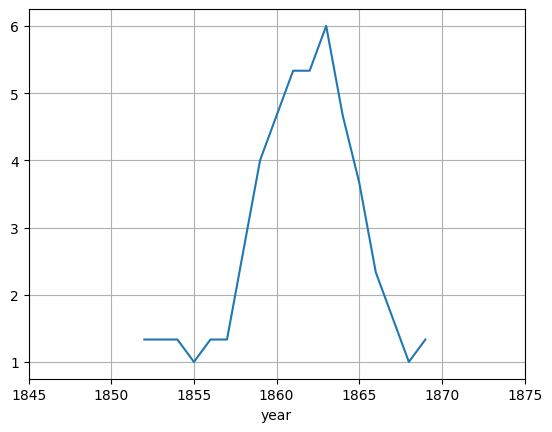

In [14]:
boekjesDF    = pd.read_csv('data/boekjes.csv')
boekjesSlice = boekjesDF.loc[boekjesDF['size'] < 50].loc[boekjesDF['size'] > 2]
boekjesSlice.groupby('year').size().rolling(3).mean().plot(xlim=(1845,1875), grid=True)

## Compare the number of Koppermaandagprenten with the number of songs

Text(0, 0.5, 'relative amount of printwork (index figures)')

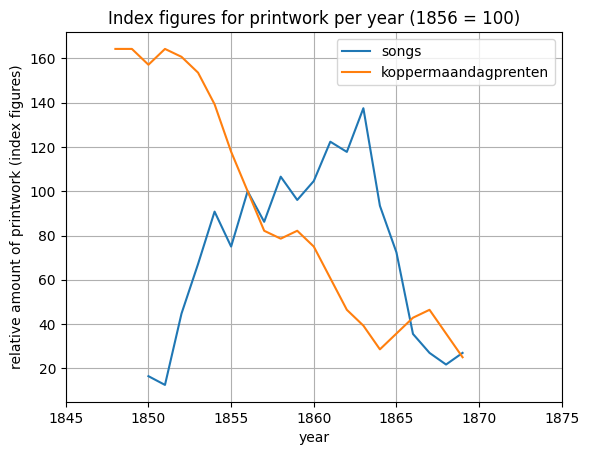

In [15]:
liedjesSerie = liedjesDF.groupby('jaartal').size().rolling(3).mean()
prentenSerie = prentenDF['count'].rolling(3).mean()

baseYear = 1856

indexCijfersLiedjes = []
for year in range(1848,1870): indexCijfersLiedjes.append((liedjesSerie.loc[year] / liedjesSerie.loc[baseYear]) * 100)

indexCijfersPrenten = []
for year in range(1848,1870): indexCijfersPrenten.append((prentenSerie.loc[year] / prentenSerie.loc[baseYear]) * 100)

indexCijfersDF = pd.DataFrame()
indexCijfersDF['year'] = range(1848,1870)
indexCijfersDF['liedjesIndex'] = indexCijfersLiedjes
indexCijfersDF['prentenIndex'] = indexCijfersPrenten

indexCijfersDF = indexCijfersDF.set_index('year')
ax = indexCijfersDF['liedjesIndex'].plot(title="Index figures for printwork per year (1856 = 100)", xlim=(1845,1875), grid=True)
ax = indexCijfersDF['prentenIndex'].plot(xlim=(1845,1875), grid=True)
ax.legend(['songs', 'koppermaandagprenten'])
ax.set_ylabel('relative amount of printwork (index figures)')



## Average size of booklets per year, in number of songs and number of words

# Topics with Top2Vec
Do the topics of songs change over time?

In [16]:
model = Top2Vec(preprocessedLiedjes)

2024-05-17 12:58:55,370 - top2vec - INFO - Pre-processing documents for training
2024-05-17 12:58:55,469 - top2vec - INFO - Creating joint document/word embedding
2024-05-17 12:58:57,920 - top2vec - INFO - Creating lower dimension embedding of documents
2024-05-17 12:59:10,599 - top2vec - INFO - Finding dense areas of documents
2024-05-17 12:59:10,624 - top2vec - INFO - Finding topics


In [17]:
model.topic_sizes

0    656
1    115
dtype: int64

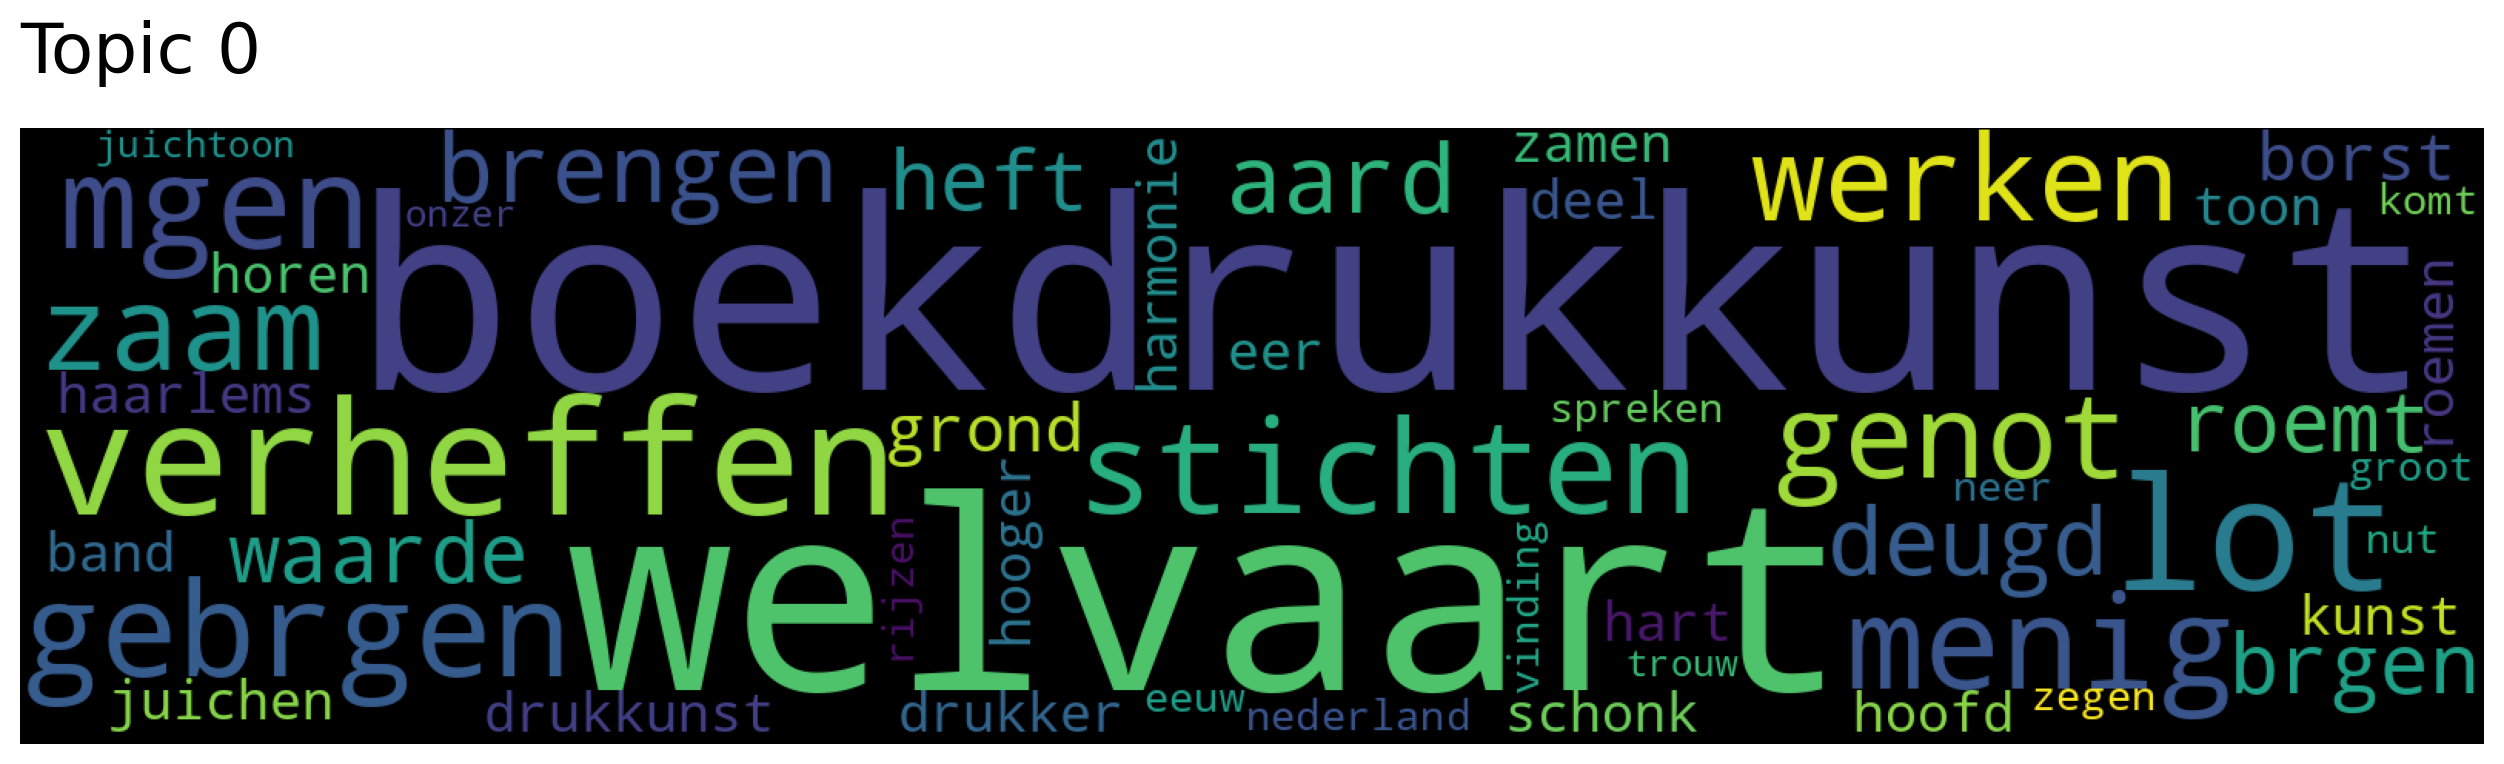

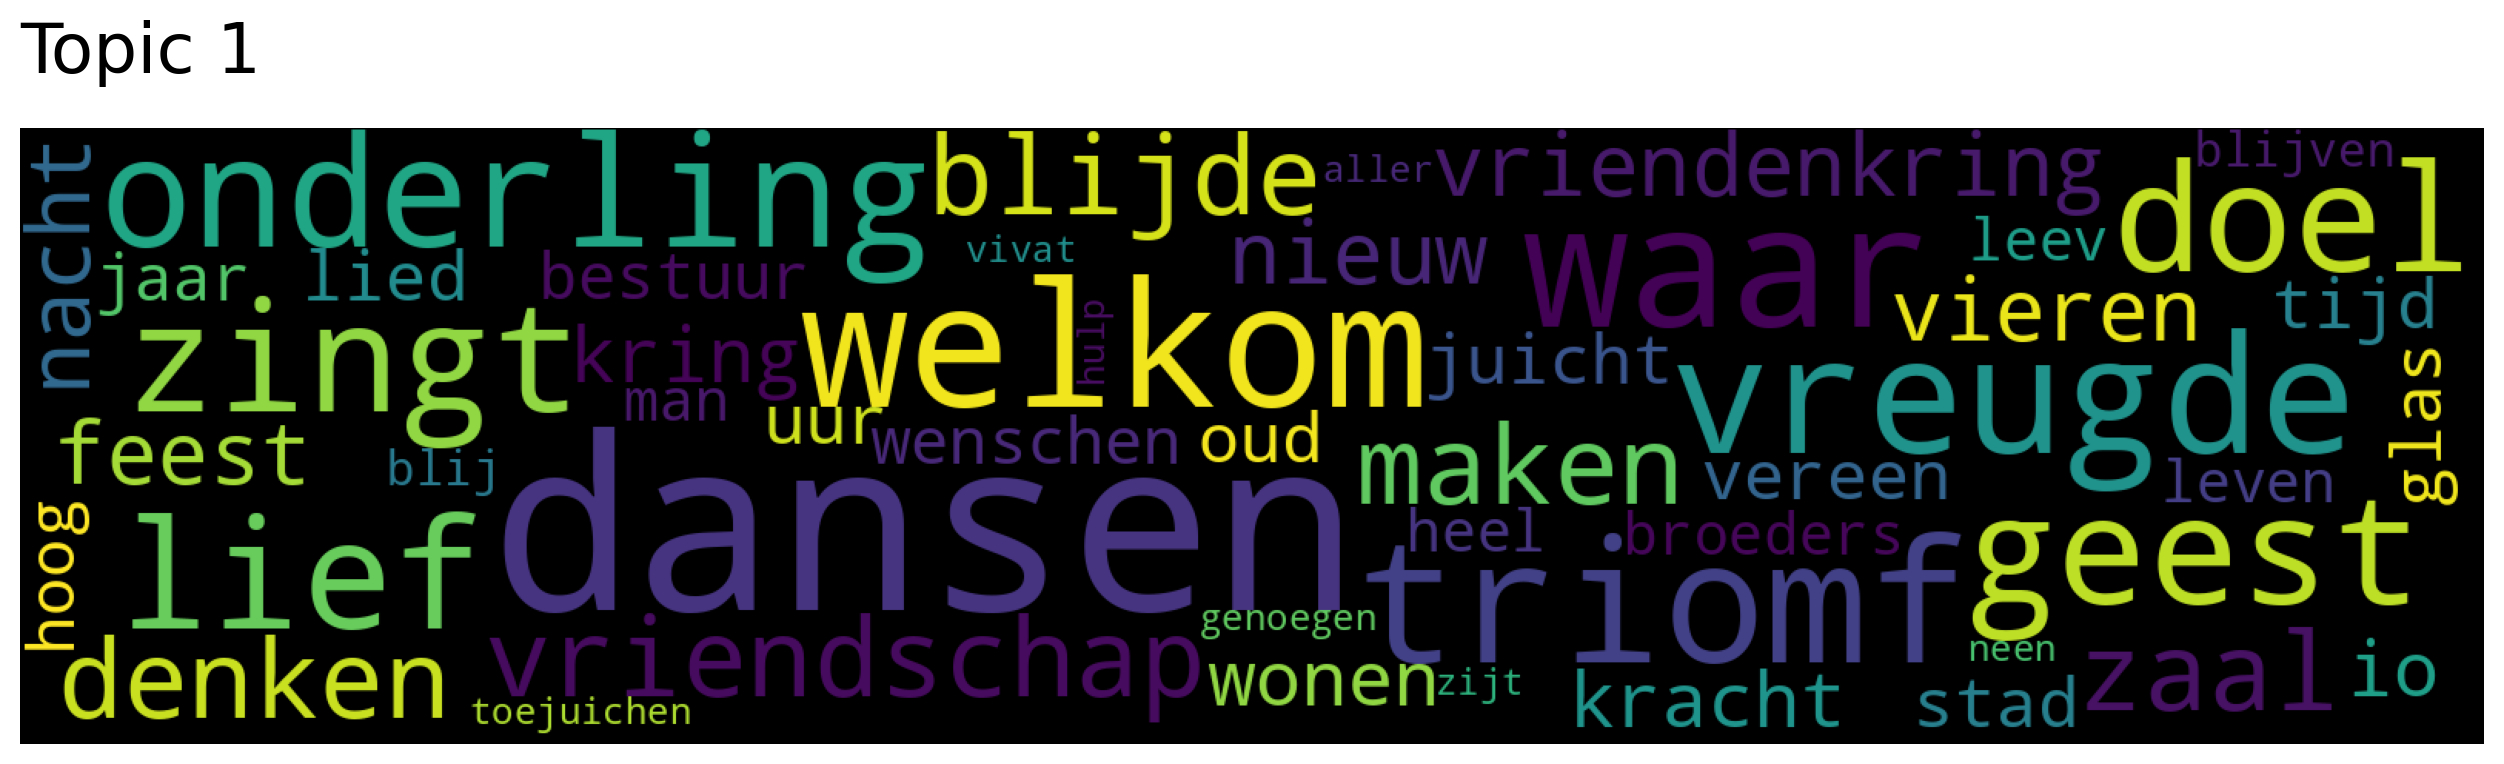

In [18]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [19]:
model.get_documents_topics([8])

(array([1]),
 array([0.9191144], dtype=float32),
 array([['dansen', 'welkom', 'triomf', 'waar', 'vreugde', 'onderling',
         'zingt', 'lief', 'geest', 'doel', 'vriendschap', 'blijde',
         'denken', 'zaal', 'maken', 'vriendenkring', 'feest', 'nieuw',
         'vieren', 'nacht', 'kring', 'wonen', 'io', 'kracht', 'juicht',
         'oud', 'vereen', 'tijd', 'stad', 'glas', 'uur', 'lied',
         'wenschen', 'jaar', 'bestuur', 'hoog', 'broeders', 'leev', 'man',
         'leven', 'heel', 'blijven', 'blij', 'toejuichen', 'aller',
         'zijt', 'neen', 'vivat', 'genoegen', 'hulp']], dtype='<U13'),
 array([[ 0.19657059, -0.61749977, -0.6464778 , -0.6482072 , -0.71612835,
         -0.7224098 , -0.7350224 , -0.7395015 , -0.7406144 , -0.7528155 ,
         -0.7610664 , -0.7723092 , -0.77389085, -0.774863  , -0.7776143 ,
         -0.78122014, -0.78445303, -0.78615177, -0.79383314, -0.7997402 ,
         -0.80191225, -0.8025004 , -0.80519634, -0.8130303 , -0.81585485,
         -0.81728005

In [20]:
doc_ids = list(range(0, len(liedjesDF)))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

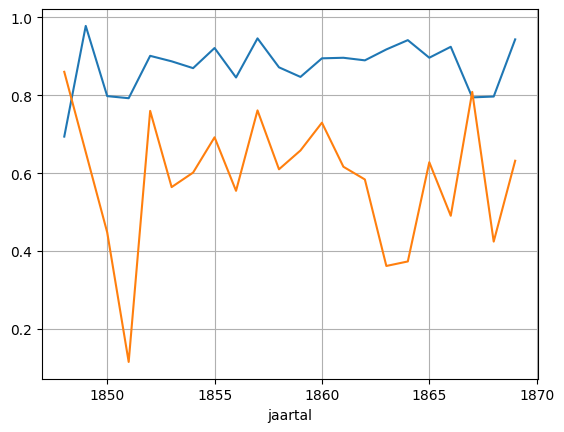

In [21]:
for topic in topic_nums:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    dfAvg['topic_score'].plot(grid=True)


# Handmade topics
I study the topics in my songs by creating handmade topics of terms that I think represent a certain topic. How much is nationalism represented in the songs? Or professional pride? This can be studied by calculating how relatively often the hand-picked terms are used in the songs. Therefor I create a document-term-matrix and vectors for every handmade topic.


In [22]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

def listify(listOfTexts):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.split()
        result.append(liedje)

    return result

def topics2vectors(topicList, vocabulary):
    result = []
    for topic in topicList:
        topicVector = []
        for term in vocabulary:
            if term in topic:
                topicVector.append(1)
            else:
                topicVector.append(0)
        result.append(topicVector)

    return result


In [33]:
listifiedLiedjes = listify(preprocessedLiedjes)
liedjesVocabulary = extract_vocabulary(listifiedLiedjes, min_count=2)
dtmLiedjes = np.array(corpus2dtm(listifiedLiedjes, liedjesVocabulary))

print(dtmLiedjes[700])

[0 0 0 ... 0 0 0]


## Topics
In the following block the hand made topics, with hand picked terms are created. 
* Topic 0: nationalistic terms
* Topic 1: monarchy and the royal family
* Topic 2: employers
* Topic 3: Laurens Koster and his statue
* Topic 4: sociability

## Calculating cosine similarity
The following block calculates the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the handmade topic vector and the documentvector per song. After that I calculate the mean cosine similarity of all the songs per year.

In [24]:
def createSimilarities(topicVectors, liedjesDF):
    for j in range(len(topicVectors)):
        topic = "topic" + str(j)
        b = topicVectors[j]
        similarities = []
        for i in range(len(liedjesDF)):
            a = dtmLiedjes[i]
            if np.linalg.norm(a) > 0:
                cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            else:
                cos_sim = 0.0
            similarities.append(cos_sim)
        liedjesDF[topic] = similarities

    return liedjesDF.groupby('jaartal').mean(numeric_only=True).rolling(1).mean(numeric_only=True)


In [25]:
topic0 = ['nederland',  'holland',  'nederlandsch', 'nederlandsche', 'nederlandschen', 'hollandsch', 'hollandsche', 'hollandschen', 'nederlands', 'nederlandse', 'nederlandsen', 'hollands', 'hollandse', 'hollandsen', 'neerlands', 'neerlandse', 'neerlandsen', 'geboortegrond',  'geboorteland',  'moederland',  'patria', 'vaderland', 'held', 'landgenoot']
topic1 = ['koning', 'vorst', 'willem', 'oranje', 'koninklijk', 'nassau']
topic2 = ['eereleden', 'beschermheer', 'donateurs', 'baas', 'patroon', 'patronen', 'burgervader', 'heeren', 'honorair', 'hooggeachte']
topic3 = ['laurens', 'lourens', 'coster', 'standbeeld', 'metalen', 'haarlem', 'spaarnestad', 'haarlemmerhout']
topic4 = ['eendragt', 'verbinden', 'zaam', 'samen', 'band', 'kring', 'zorg', 'broeder', 'trouw', 'hulp', 'vriendenkring']
topic5 = ['kunst', 'boekdrukkunst', 'drukkunst', 'schoon', 'schoonheid', 'schoone']
topic6 = ['verlichting', 'licht', 'verlichten', 'vrijheid', 'vrij', 'bevrijden', 'wetenschap', 'waarde', 'nut', 'nuttig', 'verheffen', 'beschaving', 'beschaven', 'maatschappij', 'samenleving', 'kennis', 'wijsheid', 'wijs']
topic7 = ['roem', 'roemen', 'eer', 'glorie', 'trots', 'trotsch', 'triomf', 'edel', 'eedle', 'edele', 'eere', 'fier', 'lof']
topic8 = ['loon', 'prijzen']
topic9 = ['zegelwet', 'belasting']

topicList = [topic0, topic1, topic2, topic3, topic4, topic5, topic6, topic7]
topicVectors = np.array(topics2vectors(topicList, liedjesVocabulary))

df = createSimilarities(topicVectors, liedjesDF)

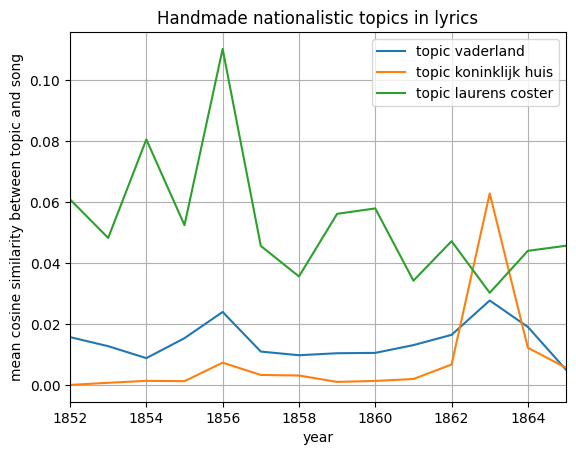

In [26]:
# Nationalisme
ax = df['topic0'].plot(title="Handmade nationalistic topics in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic1'].plot(grid=True)
ax = df['topic3'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic vaderland', 'topic koninklijk huis', 'topic laurens coster'])


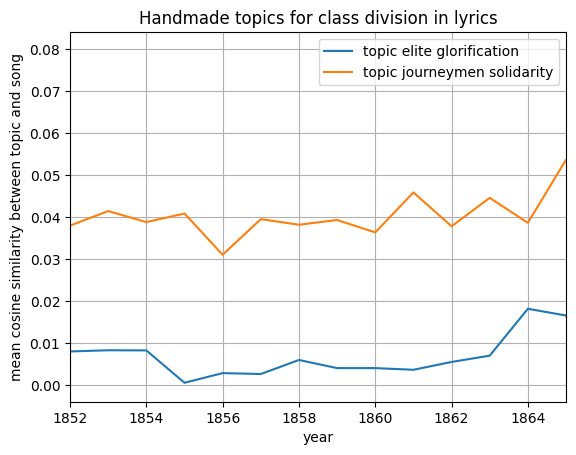

In [27]:
# Glorification of the elite vs the solidarity among printworkers
ax = df['topic2'].plot(title="Handmade topics for class division in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic4'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic elite glorification', 'topic journeymen solidarity'])


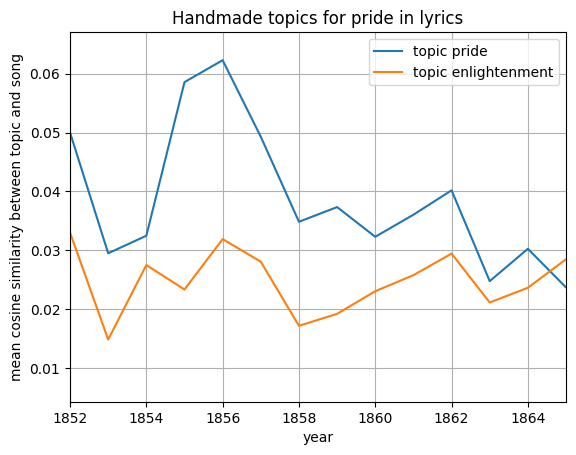

In [28]:
# Professional pride and honour
ax = df['topic7'].plot(title="Handmade topics for pride in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic6'].plot(grid=True)
# ax = df['topic5'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic pride', 'topic enlightenment'])

In [29]:
topic0 = topic0 + topic1
topic1 = topic3
topic2 = topic6 + topic7

topicListTotal = [topic0, topic1, topic2]
topicVectorsTotal = np.array(topics2vectors(topicListTotal, liedjesVocabulary))

df = createSimilarities(topicVectorsTotal, liedjesDF)

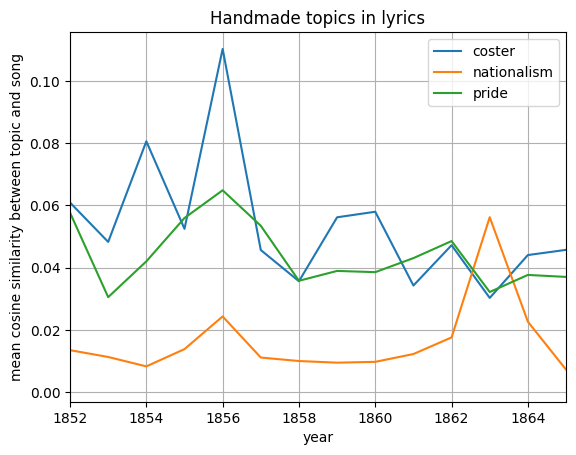

In [30]:
# Total figure
ax = df['topic1'].plot(title="Handmade topics in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic0'].plot(grid=True)
ax = df['topic2'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['coster', 'nationalism', 'pride'])

In [31]:
table = pd.crosstab([liedjesDF.typoID],[liedjesDF.jaartal], margins=True)
table.to_csv('data/liedjes-typoidXjaartal.csv')

table = pd.crosstab([boekjesDF.typoID],[boekjesDF.year], margins=True)
table.to_csv('data/boekjes-typoidXjaartal.csv')